In [1]:
# 정상 image만 학습후 결함이있는것을 선별한다.
# 금이 간 original image에서 재생성(Reconstruction)
# 두개의 image를 통해 outlier score을 계산하여 판단

In [2]:
# dataset (정상 : 2만개 / 비정상(금이 간것) : 2만개)
# https://www.kaggle.com/arunrk7/surface-crack-detection

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = 'chanwoogwak' # username
os.environ['KAGGLE_KEY'] = '' # key

In [ ]:
!kaggle datasets download -d arunrk7/surface-crack-detection

In [ ]:
!unzip -q surface-crack-detection.zip

In [4]:
# https://docs.seldon.io/projects/alibi-detect/en/latest/overview/algorithms.html
# image format과 vae(Variational Auto Encoder)를 사용
# auto encoder : input과 output을 똑같이 만들어내는 모델을 생성
# image의 추출 핵심은 latent vector
!pip install alibi_detect

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

In [6]:
# LOAD IMAGE
# Positive : crack
# Negative : normal

In [7]:
img_list = glob('Negative/*.jpg')

train_img_list, val_img_list = train_test_split(img_list, test_size=0.1, random_state=2021)

# numpy array 변환
def img_to_np(fpaths, resize=True):  
    img_array = []
    for fname in fpaths:
      try:
        # RGB변환 -> resize(64,64) -> numpy array로 변환
        img = Image.open(fname).convert('RGB')
        if(resize): img = img.resize((64, 64))
        img_array.append(np.asarray(img))
      except:
        continue
    images = np.array(img_array)
    return images

# train_data 1000개 사용
x_train = img_to_np(train_img_list)
# train_data 정규화
x_train = x_train.astype(np.float32) / 255.

# validation 32개 사용
x_val = img_to_np(val_img_list)
x_val = x_val.astype(np.float32) / 255.

print(x_train.shape)
print(x_val.shape)

(18000, 64, 64, 3)
(2000, 64, 64, 3)


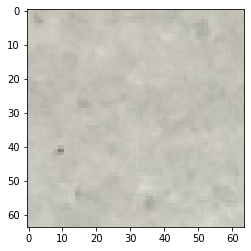

In [8]:
# 정상 이미지
plt.imshow(x_train[0])

In [9]:
# latent vector는 1024차원
latent_dim = 1024

# encoder로 차원을 축소
encoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(64, 64, 3)),
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
])

# decoder로 차원을 확장
decoder_net = tf.keras.Sequential([
    # input은 latent_vector
    InputLayer(input_shape=(latent_dim,)),
    Dense(4 * 4 * 128),
    Reshape(target_shape=(4, 4, 128)),
    # conv2DTranspose : de-convolution
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
    # 출력은 (64,64,3)으로 입력과 동일
])

od = OutlierVAE(
    threshold=.005,
    # insatance score : input image와 재생성 image의 픽셀 점수 차이
    # instance_score < 0.005 : 정상으로 판별
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

In [10]:
od.fit(
    x_train,
    epochs=30,
    verbose=True
)

282/282 [=] - 18s 61ms/step - loss: -23669.0485


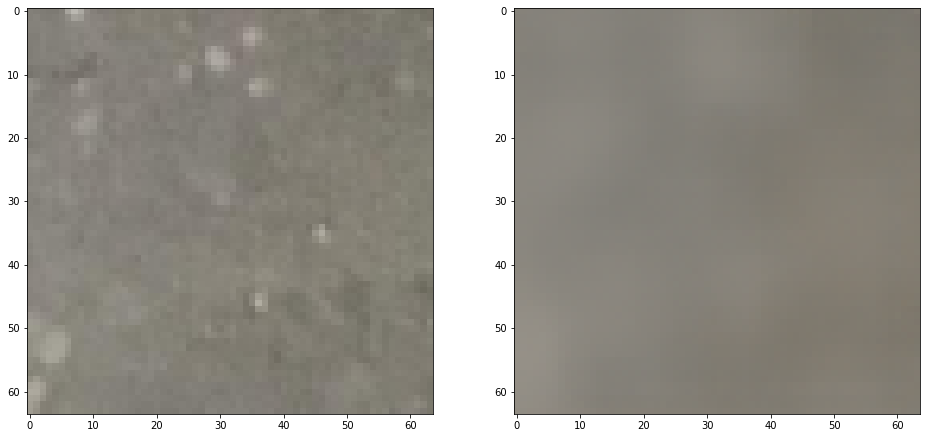

In [11]:
# train_image중 하나(12번째)를 선택하여 reconstruction
idx = 12
x = x_train[idx].reshape(1, 64, 64, 3)
x_recon = od.vae(x).numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())

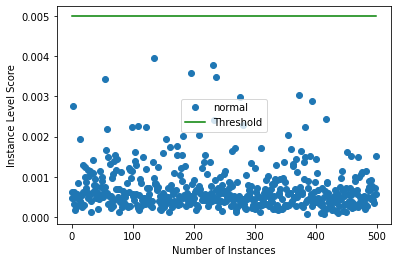

In [12]:
# validation dataset중 100개만 추출하여 예측값 확인
x_val_test = x_val[:500]
od_preds = od.predict(
    x_val_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_val_test.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)
# pixel의 차이가 적으면 아래에 위치
# threshold 아래에 위치하면 정상

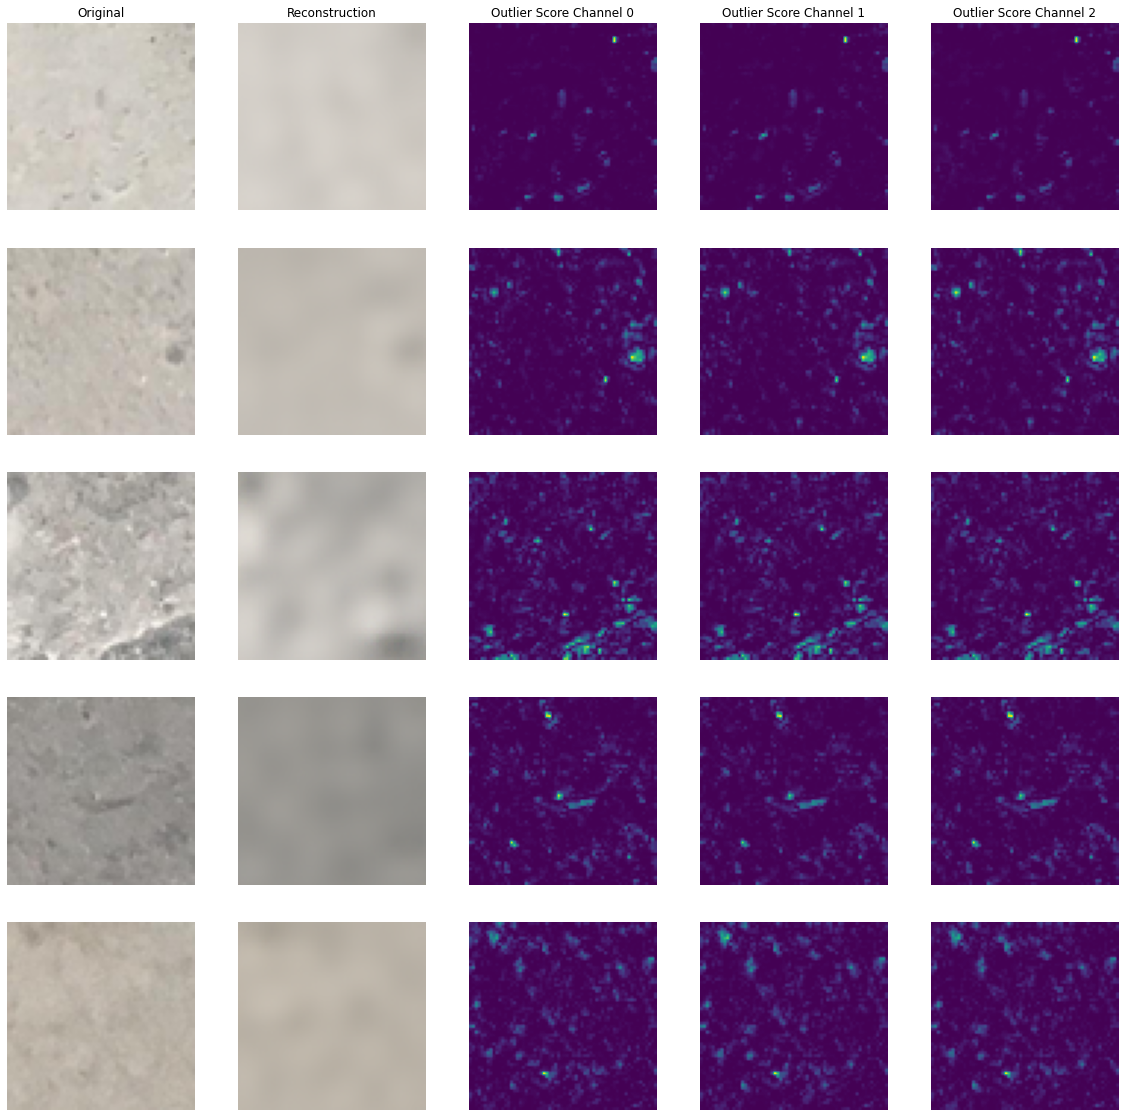

In [13]:
# original - Reconstruction =  Outlier Score 생성
x_recon = od.vae(x_val).numpy()

plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)

In [14]:
# threshold 위에 위치한(비정상) image 출력
plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=True
)

<Figure size 1440x1440 with 0 Axes>

In [15]:
# Test with crack images
test_img_list = glob('Positive/*.jpg')

x_test = img_to_np(test_img_list[:150])
x_test = x_test.astype(np.float32) / 255.

print(x_test.shape)

(150, 64, 64, 3)


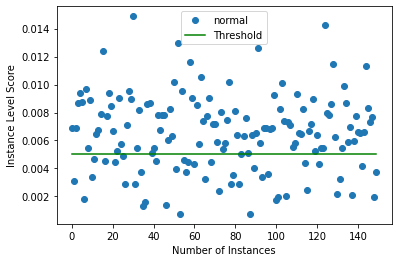

In [16]:
# crack image는 학습이 되지않아 정확도가 낮음
od_preds = od.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_test.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

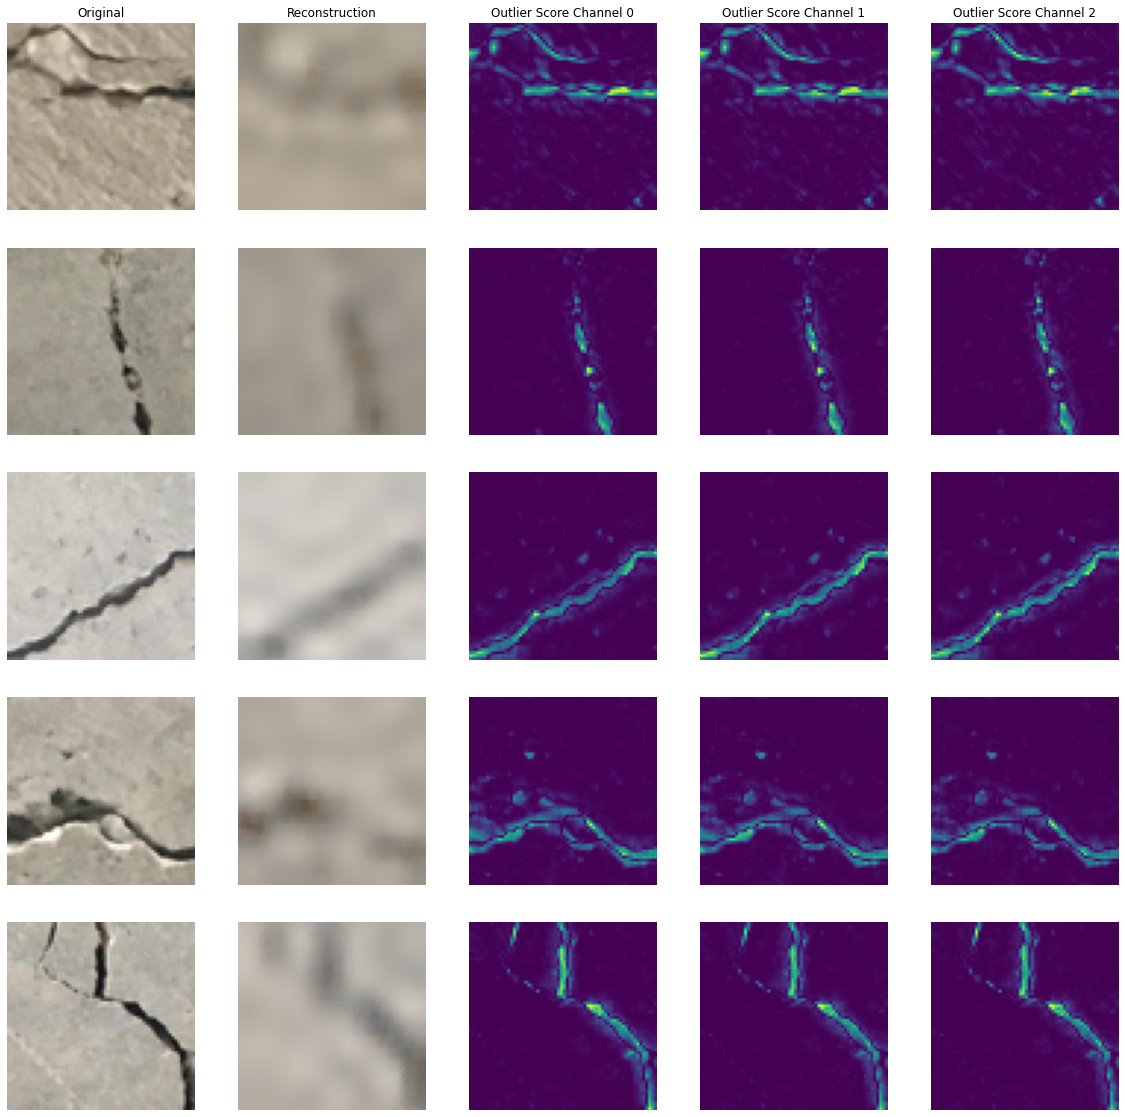

In [17]:
x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(
    od_preds,
    x_test,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)